In [5]:
using Revise
using NonEqDigits

In [6]:
using GLMakie
using CairoMakie
using JLD2
using GraphvizDotLang: attr
using GraphvizDotLang

In [7]:
single_col_width = 324 # corresponds to 3+3/8 in as state in PR guidelines
double_col_width = single_col_width*2
golden_ratio = 1.618
nothing

# Testing

In [8]:
function prep_p1(rules;
        size=(double_col_width, double_col_width/golden_ratio),
        kwargs...
    )
    fig = Figure(; size)
    ax = Axis(fig[1,1];
        xticks = (1:length(rs), string.(rs)),
        xticklabelsize=8.,
        xticklabelrotation=pi/2,
        xgridvisible=false,
        xautolimitmargin = (0.01, 0.01),
        xlabel="Rule",
        kwargs...
    )

    fig, ax
end

prep_p1 (generic function with 1 method)

# Kymograph

## v2

In [1002]:
using GillespieSim
function run_gs_for_kymo2(ma, start_state, num_steps=10; kwargs...)
    gs = Gillespie(ma, 0., start_state);
    
    vs = [gs.cur_state]
    ts = [gs.cur_time]

    finished_in_ssac = false

    for i in 1:num_steps
        ns = GillespieSim.next_step(gs)
        if isnothing(ns)
            finished_in_ssac = true
            break
        end

        (dt, nstate) = ns
        gs.cur_time += dt
        gs.cur_state = nstate

        push!(ts, gs.cur_time)
        push!(vs, gs.cur_state)
    end

    if finished_in_ssac
        push!(ts, Inf)
    else
        pop!(vs)
    end
    
    states = label_for.(Ref(ma.mg), vs);

    ts, vs, states
end

run_gs_for_kymo2 (generic function with 2 methods)

In [1100]:
function plot_kymograph2!(ax, ts, xs;
        inf_time=0.2,
        kwargs...
)
    L = length(xs[1])
    num_states_to_plot = length(xs)
    
    xx = Matrix{Union{Missing,Int}}(undef, L, num_states_to_plot)
    for i in 1:num_states_to_plot
        for j in 1:L
            if xs[i][j] == 1
                xx[j,i] = 1
            else
                xx[j,i] = 0
            end
        end
    end

    ax.title = "Kymograph of a Gillespie sim"
    ax.yreversed = true
    ax.ylabel = "time"
    ax.ygridvisible = false
    ax.xgridvisible = false
    ax.xticks = (1:L, [(@sprintf "N%d" i) for i in 1:L])

    hashitac = ts[end] == Inf
    if hashitac
        ts = copy(ts)
        ts[end] = ts[end-1] + inf_time
    end
    
    p = heatmap!(ax, 0.5:1:(L+0.5), ts, xx; kwargs...)

    if hashitac
        hlines!(ax, [ts[end-1]]; color=:red)
        text!(ax, 1, ts[end-1];
            align=(:left, :top),
            text="Reached stable state",
            color=:red
        )
    end
    
    p
end

function plot_kymograph2(ts, xs;
        fig=(;), axis=(;), kwargs...
)
    fig = Figure(;
        size=(single_col_width, single_col_width*golden_ratio),
        fontsize=10,
        fig...
    )
    ax = Axis(fig[1,1]; axis...)

    p = plot_kymograph2!(ax, ts, xs; kwargs...)
    
    Makie.FigureAxisPlot(fig, ax, p)
end


plot_kymograph2 (generic function with 1 method)

In [1130]:
function do_gs_and_kymograph!(ax, L, rule, reduced=false, nsteps=100, ss=nothing;
        include_nonsshline=true,
        kwargs...
    )
    ma = MolAut(L, rule; reduced)

    if isnothing(ss)
        ss = rand(1:nv(ma.mg))
    end
    
    ts, vs, states = run_gs_for_kymo2(ma, ss, nsteps)
    p = plot_kymograph2!(ax, ts, states; kwargs...)
    ax.title = ax.title[] * "\n L=$L, rule=$(full_code_label(rule; short=true, numenzymes=true)), red=$reduced"

    if include_nonsshline
        acs = attracting_components(ma.mg)
        vs_in_acs = reduce(vcat, filter(ac->length(ac) > 1, acs); init=[])
        acvi = findfirst(v->v in vs_in_acs, vs)
    
        if !isnothing(acvi)
            hlines!(ax, [ts[acvi]]; color=:blue)
            text!(ax, 1, ts[acvi];
                align=(:left, :top),
                text="Reached non-ss ac",
                color=:blue
            )
        end
    end
    
    p
end
function do_gs_and_kymograph(L, args...;
        fig=(;),
        axis=(;),
        kwargs...
    )
    fig = Figure(;
        size=(single_col_width, single_col_width*golden_ratio),
        fontsize=10,
        fig...
    )
    ax = Axis(fig[1,1]; axis...)

    p = do_gs_and_kymograph!(ax, args...; kwargs...)

    Makie.FigureAxisPlot(fig, ax, p)
end

do_gs_and_kymograph (generic function with 5 methods)

### 142, multiruns

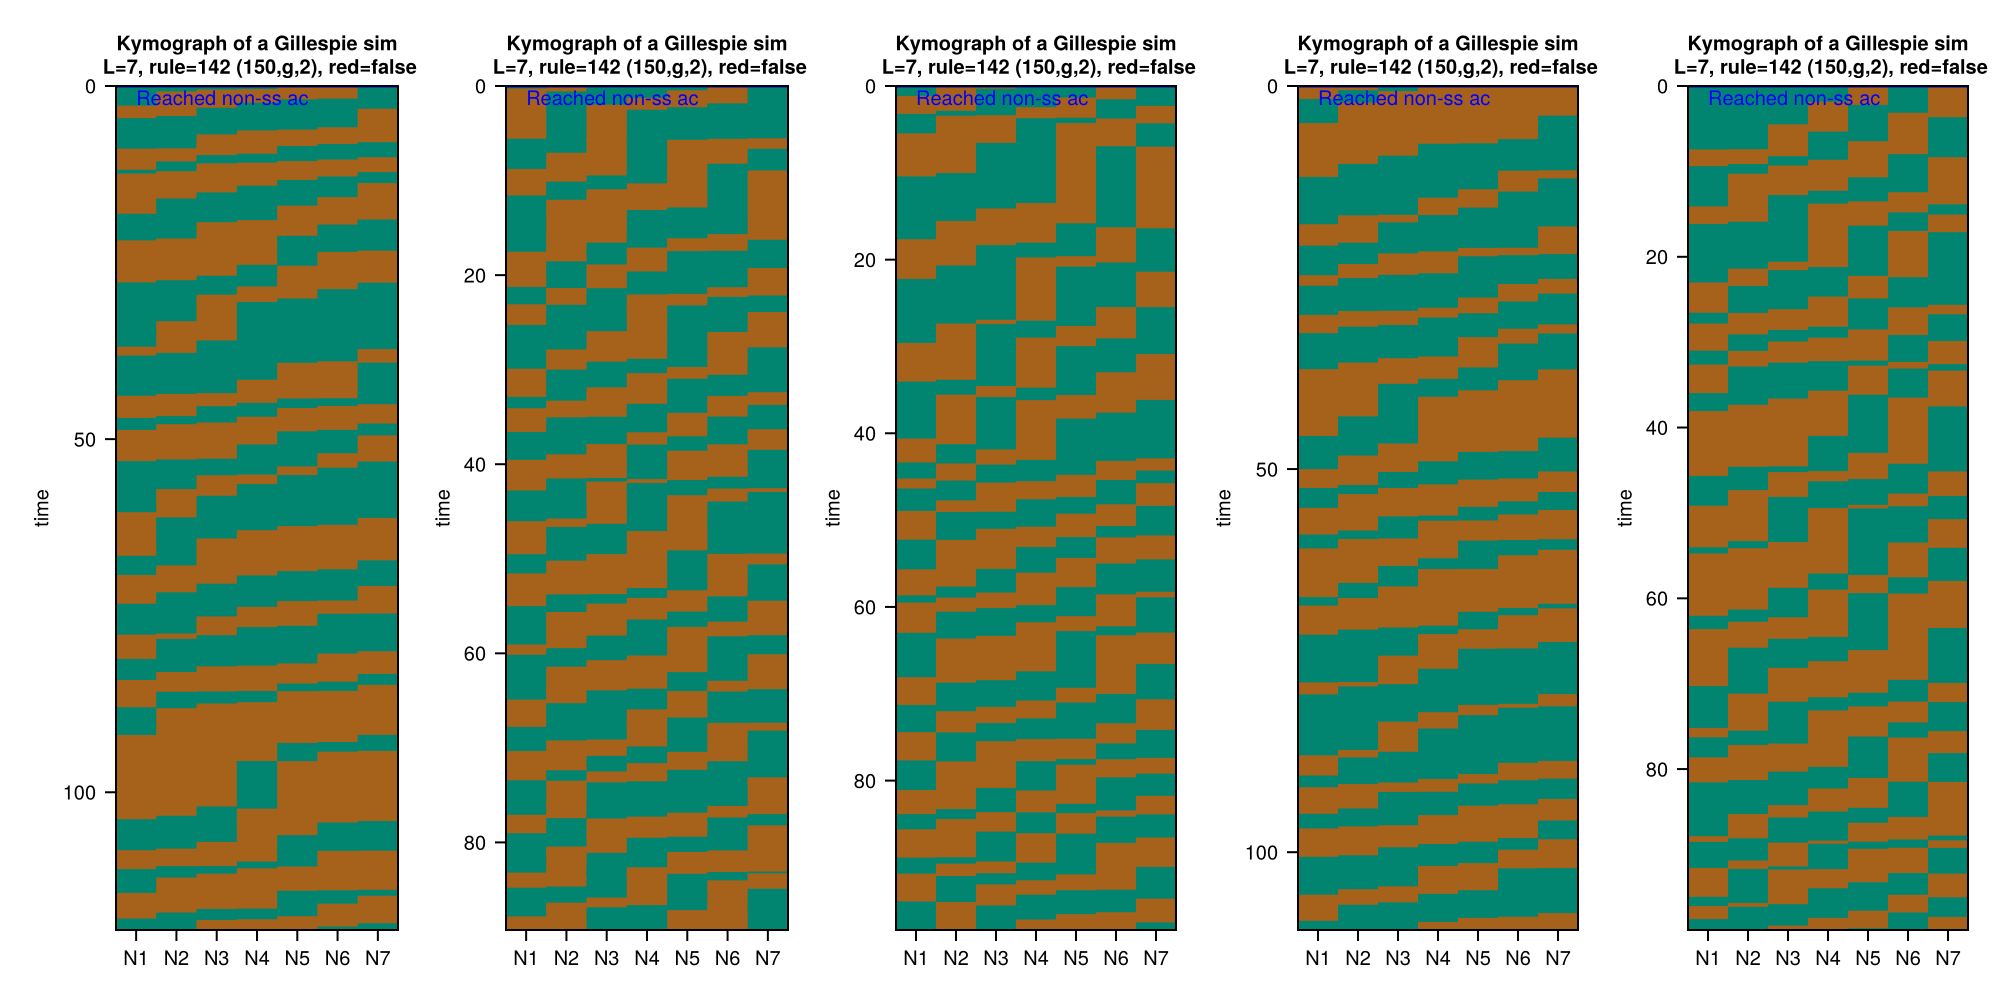

In [1131]:
num_runs = 5
single_width = 200

f = Figure(;
    size=(num_runs*single_width, 500),
    fontsize=10,
)

for i in 1:num_runs
    ax = Axis(f[1,i])
    do_gs_and_kymograph!(ax, 7, 142, false, 200, nothing; colormap=:BrBG_5)
end

f

In [1036]:
save("../data/kymograph_drafts/r142_5plots.pdf", f)

CairoMakie.Screen{PDF}


### Many plots

In [1132]:
num_runs = 10
single_width = 200

# for r in [134, 142, 38, 46, 62, 3, 11, 19, 25, 27, 33, 35, 41, 43]
for r in [134, 142, 6, 14, 30, 38, 46, 62, 3, 7, 11, 15, 19, 25, 27, 33, 35, 37, 41, 43, 45]
    for L in [5, 6]
        f = Figure(;
            size=(num_runs*single_width, 500),
            fontsize=10,
        )
        
        ps = []
        for i in 1:num_runs
            ax = Axis(f[1,i])
            p = do_gs_and_kymograph!(ax, L, r, false, 200, nothing; colormap=Categorical(:BrBG_5))
            push!(ps, p)
        end
        Colorbar(f[1,num_runs+1], ps[end])

        save("../data/kymograph_drafts/many1/L$(L)_r$(r).pdf", f)
    end
end

### Testing

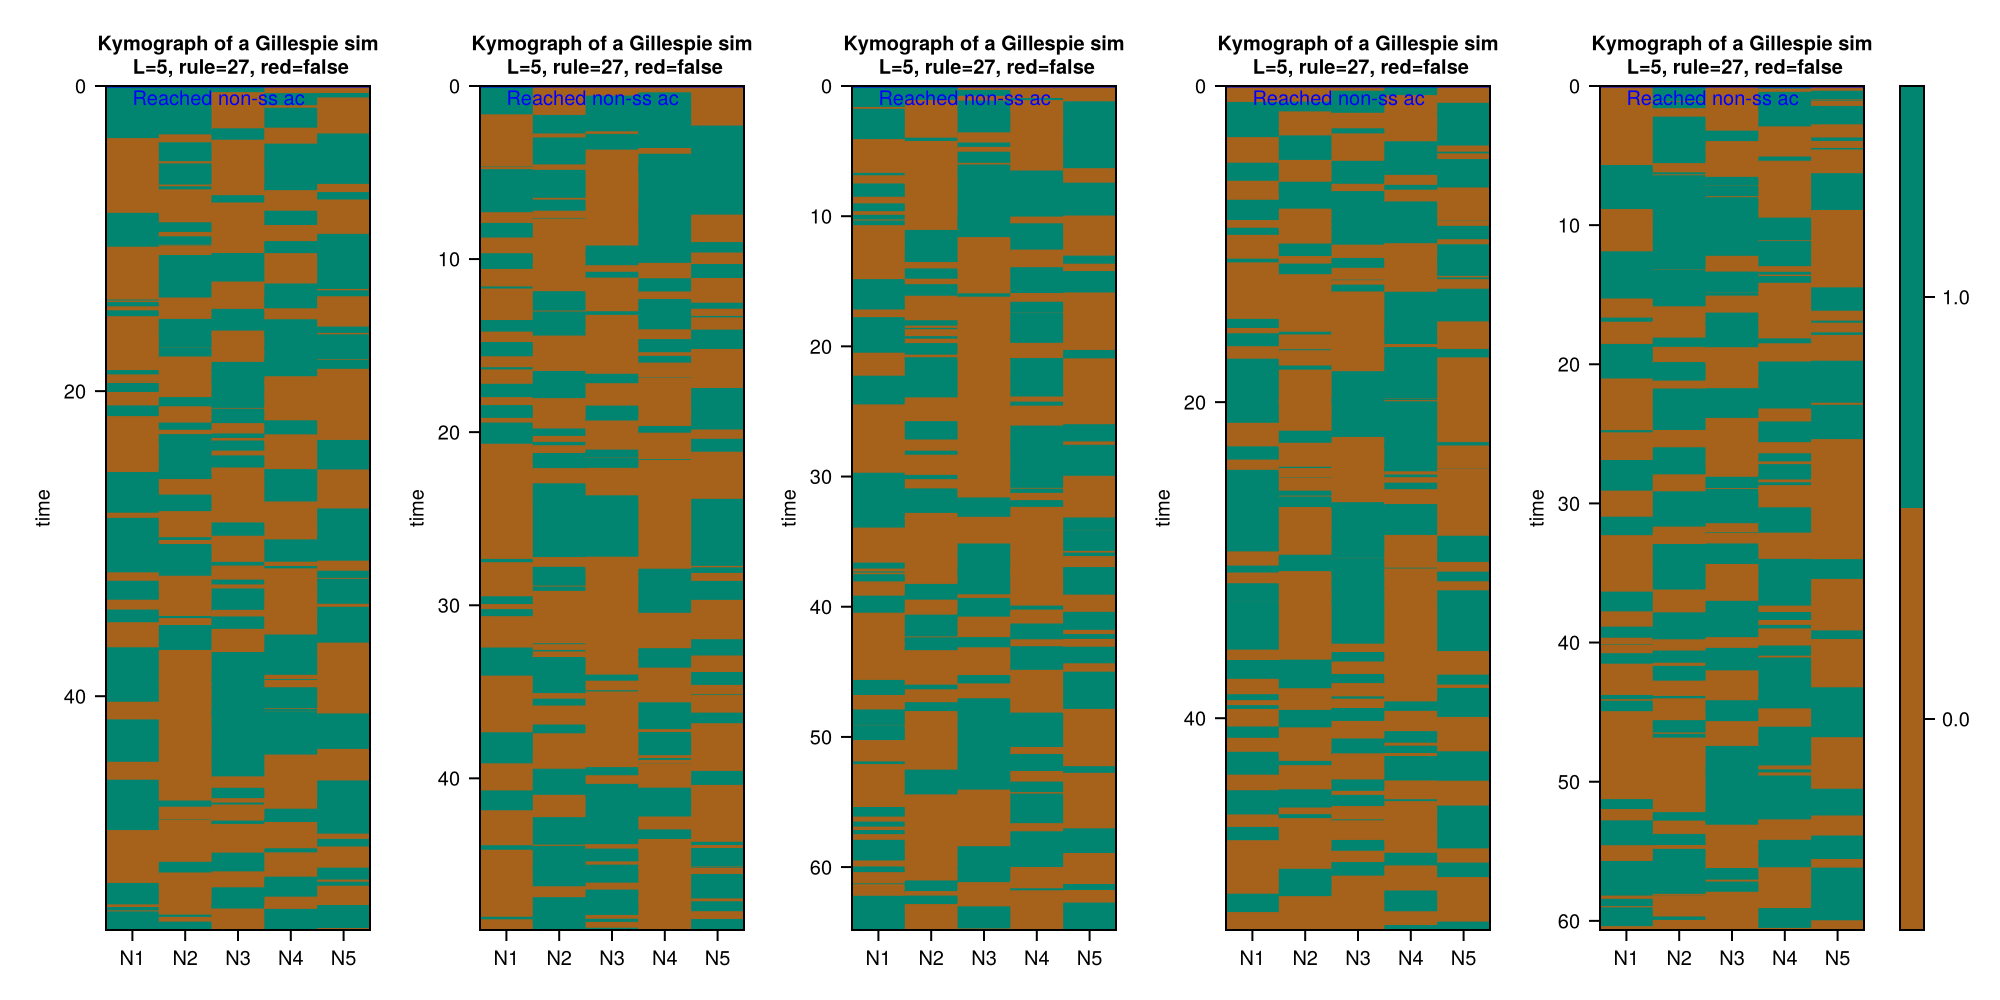

In [1112]:
num_runs = 5
single_width = 200

f = Figure(;
    size=(num_runs*single_width, 500),
    fontsize=10,
)

ps = []
for i in 1:num_runs
    ax = Axis(f[1,i])
    p = do_gs_and_kymograph!(ax, 5, 27, false, 200, nothing; colormap=Categorical(:BrBG_5))
    push!(ps, p)
end
Colorbar(f[1,num_runs+1], ps[end])

f

In [1087]:
save("../data/kymograph_drafts/r46_L7_5plots.pdf", f)

CairoMakie.Screen{PDF}


### Testing

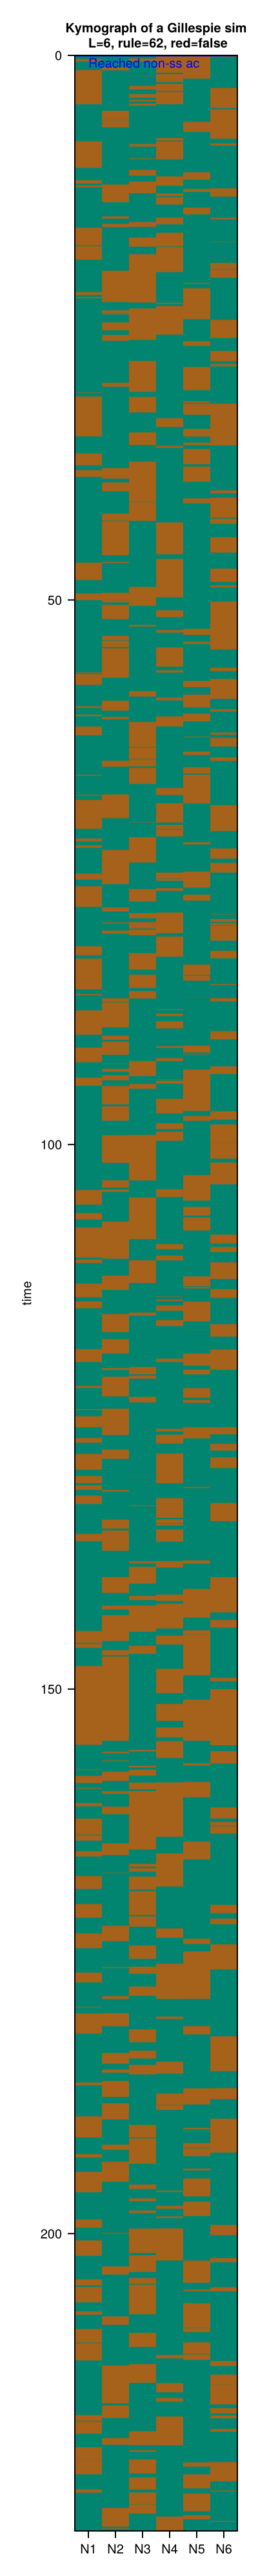

In [1007]:
do_gs_and_kymograph(6, 62, false, 1000, 7; fig=(; size=(200, 2000)), colormap=:BrBG_5)

## Testing v1

In [424]:
using GillespieSim
function run_gs_for_kymo(ma, start_state; kwargs...)
    gs = Gillespie(ma, 0., start_state);
    
    vs = [gs.cur_state]
    ts = [gs.cur_time]
    function cb(gs)
        push!(vs, gs.cur_state)
        push!(ts, gs.cur_time)
    end
    run_gillespie!(gs;
        callback=cb,
        kwargs...
    )
    
    states = label_for.(Ref(ma.mg), vs);

    ts, states
end

run_gs_for_kymo (generic function with 1 method)

In [538]:
function plot_kymograph(ts, xs; fig=(;), axis=(;), plot=(;))
    L = length(xs[1])
    if length(ts) != length(xs)
        @error "somethings funny"
    end
    # skips last state as we need an end time
    num_states_to_plot = length(xs) - 1

    if num_states_to_plot < 1
        @error "no states given"
    end

    xx = Matrix{Union{Missing,Int}}(undef, L, num_states_to_plot)
    for i in 1:num_states_to_plot
        for j in 1:L
            if xs[i][j] == 1
                xx[j,i] = 1
            else
                xx[j,i] = missing
            end
        end
    end
    
    fig = Figure(;
        size=(single_col_width, single_col_width*golden_ratio),
        fontsize=10,
        fig...
    )
    ax = Axis(fig[1,1];
        title="Gillespie simulation kymostat plot",
        yreversed=true,
        ylabel="time",
        ygridvisible=false,
        xgridvisible=false,
        xticks=(1:L, [(@sprintf "N%d" i) for i in 1:L]),
        axis...
    )
    
    p = heatmap!(ax, 0.5:1:(L+0.5), ts, xx; plot...)
    
    Makie.FigureAxisPlot(fig, ax, p)
end


plot_kymograph (generic function with 1 method)

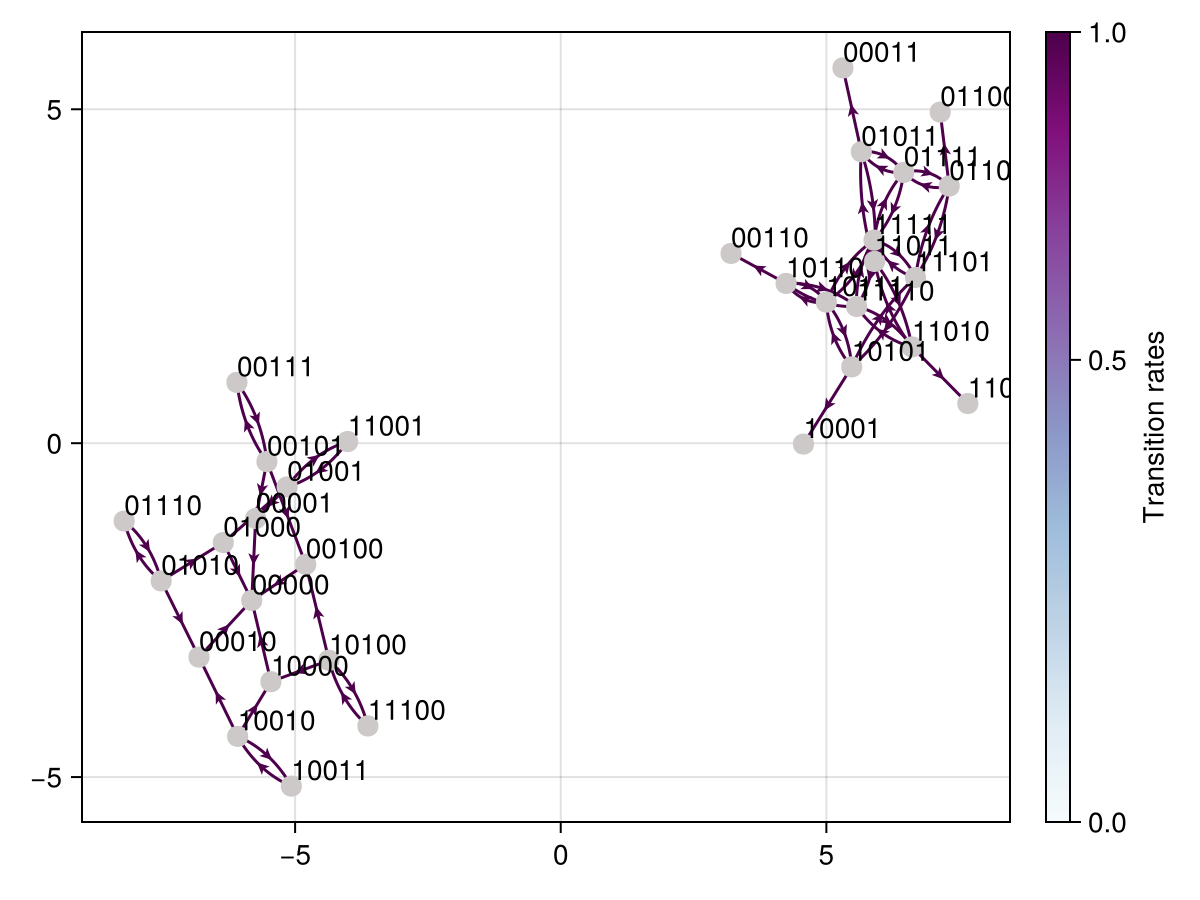

In [583]:
L = 5
rule = 104
reduced = false
# reduced = true
ma = MolAut(L, rule; reduced);
plotgm(ma)

In [584]:
findfirst(x->x==[0,1,0,1,0], collect(labels(ma.mg)))

11

In [597]:
states

2-element Vector{Vector{Int64}}:
 [1, 1, 0, 1, 0]
 [1, 1, 0, 0, 0]

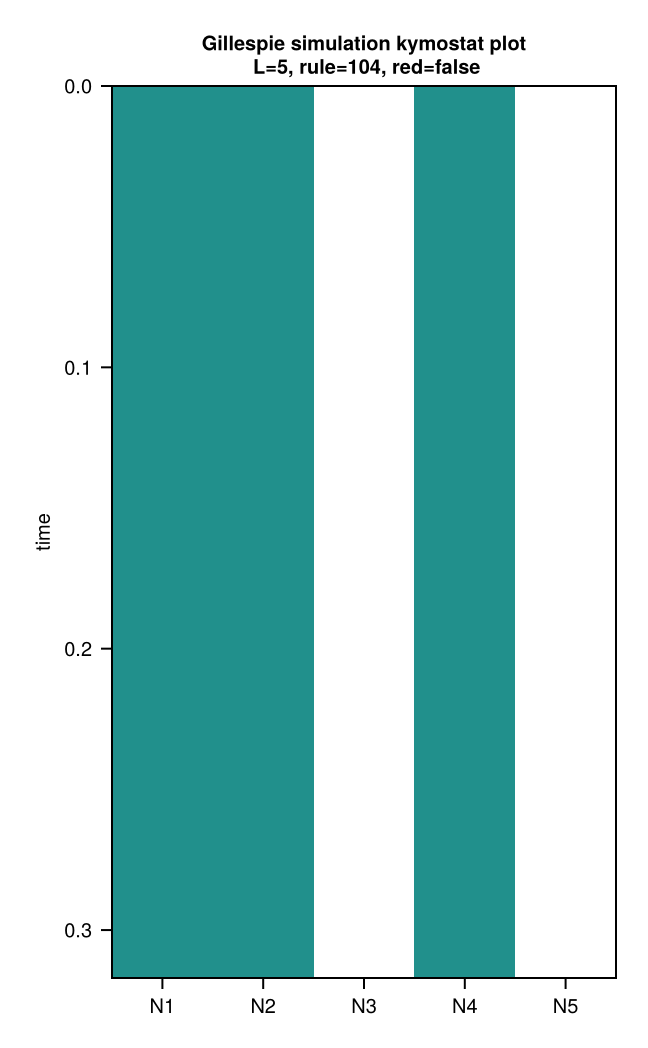

In [596]:
ss = rand(1:nv(ma.mg))
# ss = 2
ts, states = run_gs_for_kymo(ma, ss; exit_steps=100);
fap = plot_kymograph(ts, states)

fap.axis.title = fap.axis.title[] * "\n L=$L, rule=$rule, red=$reduced"

fap
# display(GLMakie.Screen(), fap)

# Main fig 3

# Bits and bobs

In [3]:
GC.gc()
empty!(Out)
GC.gc()